In [1]:
# Import statements
import tweepy
from tweepy import OAuthHandler
import json
from timeit import default_timer as timer
import pandas as pd
from datetime import datetime
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

## Gathering

In [2]:
# Load the enhanced twitter archive file we were given
archive = pd.read_csv('twitter-archive-enhanced.csv')
archive

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [3]:
# Scrape the image predictions file from the Udacity website
import requests

url='https://d17h27t6h515a5.cloudfront.net/topher/2017/August/599fd2ad_image-predictions/image-predictions.tsv'
try:
    response = requests.get(url)
except Exception as err:
    print(err)
with open('image_predictions.tsv', mode = 'wb') as file:
    file.write(response.content)

In [4]:
# Load the image predictions file
image = pd.read_csv('image_predictions.tsv', sep='\t')
image

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,666020888022790149,https://pbs.twimg.com/media/CT4udn0WwAA0aMy.jpg,1,Welsh_springer_spaniel,0.465074,True,collie,0.156665,True,Shetland_sheepdog,0.061428,True
1,666029285002620928,https://pbs.twimg.com/media/CT42GRgUYAA5iDo.jpg,1,redbone,0.506826,True,miniature_pinscher,0.074192,True,Rhodesian_ridgeback,0.072010,True
2,666033412701032449,https://pbs.twimg.com/media/CT4521TWwAEvMyu.jpg,1,German_shepherd,0.596461,True,malinois,0.138584,True,bloodhound,0.116197,True
3,666044226329800704,https://pbs.twimg.com/media/CT5Dr8HUEAA-lEu.jpg,1,Rhodesian_ridgeback,0.408143,True,redbone,0.360687,True,miniature_pinscher,0.222752,True
4,666049248165822465,https://pbs.twimg.com/media/CT5IQmsXIAAKY4A.jpg,1,miniature_pinscher,0.560311,True,Rottweiler,0.243682,True,Doberman,0.154629,True
...,...,...,...,...,...,...,...,...,...,...,...,...
2070,891327558926688256,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,2,basset,0.555712,True,English_springer,0.225770,True,German_short-haired_pointer,0.175219,True
2071,891689557279858688,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,1,paper_towel,0.170278,False,Labrador_retriever,0.168086,True,spatula,0.040836,False
2072,891815181378084864,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,1,Chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
2073,892177421306343426,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,1,Chihuahua,0.323581,True,Pekinese,0.090647,True,papillon,0.068957,True


In [5]:
# Setting up the Twitter API with authentication pieces
consumer_key = ''
consumer_secret = ''
access_token = ''
access_secret = ''

auth = OAuthHandler(consumer_key, consumer_secret)
auth.set_access_token(access_token, access_secret)

api = tweepy.API(auth, wait_on_rate_limit=True)

In [6]:
# Query Twitter's API for JSON data for each tweet ID in the Twitter archive
count = 0
fails_dict = {}
start = timer()
# Save each tweet's returned JSON as a new line in a .txt file
with open('tweet_json.txt', 'w') as outfile:
   # This loop will likely take 20-30 minutes to run because of Twitter's rate limit
   for tweet_id in archive['tweet_id']:
       count += 1
       print(str(count) + ": " + str(tweet_id))
       try:
           tweet = api.get_status(tweet_id, tweet_mode='extended')
           print("Success")
           json.dump(tweet._json, outfile)
           outfile.write('\n')
       except tweepy.TweepError as e:
           print("Fail")
            
           fails_dict[tweet_id] = e
           pass
end = timer()
print(end - start)
print(fails_dict)

In [7]:
# Load the Twitter API data

tweet_js = pd.read_json('tweet_json.txt', lines=True)
tweet_js['tweet_id'] = tweet_js['id']
tweet_js = tweet_js[['tweet_id','favorite_count','retweet_count']]
tweet_js.head(5)

,tweet_id,favorite_count,retweet_count
0,892420643555336193,36112,7692
1,892177421306343426,31159,5689
2,891815181378084864,23463,3774
3,891689557279858688,39399,7858
4,891327558926688256,37625,8465


## Assessing

In [8]:
archive.sample(5)

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
40,884562892145688576,NaN,NaN,2017-07-11 00:00:02 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Kevin. He's just so happy. 13/10 what ...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/884562892...,13,10,Kevin,None,None,None,None
1345,704491224099647488,7.044857e+17,28785486.0,2016-03-01 02:19:31 +0000,"<a href=""http://twitter.com/download/iphone"" r...",13/10 hero af\n@ABC,NaN,NaN,NaN,NaN,13,10,None,None,None,None,None
305,836260088725786625,NaN,NaN,2017-02-27 17:01:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Lucy. She spent all morning overseeing...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/836260088...,13,10,Lucy,None,None,None,None
2087,670797304698376195,NaN,NaN,2015-11-29 02:51:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Trigger. He was minding his own busine...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/670797304...,11,10,Trigger,None,None,None,None
1266,709852847387627521,NaN,NaN,2016-03-15 21:24:41 +0000,"<a href=""http://twitter.com/download/iphone"" r...",*lets out a tiny whimper and then collapses* ....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/709852847...,12,10,None,None,None,None,None


In [9]:
archive.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2356 entries, 0 to 2355
Data columns (total 17 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   tweet_id                    2356 non-null   int64  
 1   in_reply_to_status_id       78 non-null     float64
 2   in_reply_to_user_id         78 non-null     float64
 3   timestamp                   2356 non-null   object 
 4   source                      2356 non-null   object 
 5   text                        2356 non-null   object 
 6   retweeted_status_id         181 non-null    float64
 7   retweeted_status_user_id    181 non-null    float64
 8   retweeted_status_timestamp  181 non-null    object 
 9   expanded_urls               2297 non-null   object 
 10  rating_numerator            2356 non-null   int64  
 11  rating_denominator          2356 non-null   int64  
 12  name                        2356 non-null   object 
 13  doggo                       2356 

In [10]:
archive.tweet_id.value_counts()

749075273010798592    1
741099773336379392    1
798644042770751489    1
825120256414846976    1
769212283578875904    1
                     ..
715360349751484417    1
666817836334096384    1
794926597468000259    1
673705679337693185    1
700151421916807169    1
Name: tweet_id, Length: 2356, dtype: int64

In [11]:
archive.rating_numerator.value_counts()

12      558
11      464
10      461
13      351
9       158
8       102
7        55
14       54
5        37
6        32
3        19
4        17
1         9
2         9
420       2
0         2
15        2
75        2
80        1
20        1
24        1
26        1
44        1
50        1
60        1
165       1
84        1
88        1
144       1
182       1
143       1
666       1
960       1
1776      1
17        1
27        1
45        1
99        1
121       1
204       1
Name: rating_numerator, dtype: int64

In [12]:
archive.rating_denominator.value_counts()

10     2333
11        3
50        3
80        2
20        2
2         1
16        1
40        1
70        1
15        1
90        1
110       1
120       1
130       1
150       1
170       1
7         1
0         1
Name: rating_denominator, dtype: int64

In [13]:
archive.source.value_counts()

<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>     2221
<a href="http://vine.co" rel="nofollow">Vine - Make a Scene</a>                          91
<a href="http://twitter.com" rel="nofollow">Twitter Web Client</a>                       33
<a href="https://about.twitter.com/products/tweetdeck" rel="nofollow">TweetDeck</a>      11
Name: source, dtype: int64

In [14]:
archive.text.value_counts()

Meet Crouton. He's a Galapagos Boonwiddle. Has a legendary tongue (most Boonwiddles do). Excellent stuff 10/10 https://t.co/110Eeg7KW3                       1
This is Gus. He likes to be close to you, which is good because you want to be close to Gus. 12/10 would boop then pet https://t.co/DrsrQkEfnb               1
I can't believe this keeps happening. This, is a birb taking a bath. We only rate dogs. Please only send dogs. Thank you... 12/10 https://t.co/pwY9PQhtP2    1
Here's a doggo questioning his entire existence. 10/10 someone tell him he's a good boy  https://t.co/dVm5Hgdpeb                                             1
This is Oscar. He has legendary eyebrows and he h*ckin knows it. Curly af too. 12/10 would hug passionately https://t.co/xuxZoObmF0                          1
                                                                                                                                                            ..
holy shit 12/10 https://t.co/p6O8X93bTQ       

In [15]:
archive.expanded_urls.value_counts()

https://twitter.com/dog_rates/status/698195409219559425/photo/1                                                                                                                                    2
https://twitter.com/dog_rates/status/704761120771465216/photo/1,https://twitter.com/dog_rates/status/704761120771465216/photo/1                                                                    2
https://twitter.com/dog_rates/status/783839966405230592/photo/1,https://twitter.com/dog_rates/status/783839966405230592/photo/1,https://twitter.com/dog_rates/status/783839966405230592/photo/1    2
https://twitter.com/dog_rates/status/786963064373534720/photo/1                                                                                                                                    2
https://twitter.com/dog_rates/status/681694085539872773/photo/1                                                                                                                                    2
               

In [16]:
archive.name.value_counts()

None       745
a           55
Charlie     12
Lucy        11
Cooper      11
          ... 
Jimbo        1
Ronnie       1
Hazel        1
Zeek         1
Amy          1
Name: name, Length: 957, dtype: int64

In [17]:
archive.doggo.value_counts()

None     2259
doggo      97
Name: doggo, dtype: int64

In [18]:
archive.floofer.value_counts()

None       2346
floofer      10
Name: floofer, dtype: int64

In [19]:
archive.pupper.value_counts()

None      2099
pupper     257
Name: pupper, dtype: int64

In [20]:
archive.puppo.value_counts()

None     2326
puppo      30
Name: puppo, dtype: int64

In [21]:
archive[archive['expanded_urls'].isnull()]

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
30,886267009285017600,8.862664e+17,2.281182e+09,2017-07-15 16:51:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@NonWhiteHat @MayhewMayhem omg hello tanner yo...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
55,881633300179243008,8.816070e+17,4.738443e+07,2017-07-02 21:58:53 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@roushfenway These are good dogs but 17/10 is ...,NaN,NaN,NaN,NaN,17,10,None,None,None,None,None
64,879674319642796034,8.795538e+17,3.105441e+09,2017-06-27 12:14:36 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@RealKentMurphy 14/10 confirmed,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
113,870726314365509632,8.707262e+17,1.648776e+07,2017-06-02 19:38:25 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@ComplicitOwl @ShopWeRateDogs &gt;10/10 is res...,NaN,NaN,NaN,NaN,10,10,None,None,None,None,None
148,863427515083354112,8.634256e+17,7.759620e+07,2017-05-13 16:15:35 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Jack_Septic_Eye I'd need a few more pics to p...,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
179,857214891891077121,8.571567e+17,1.806710e+08,2017-04-26 12:48:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@Marc_IRL pixelated af 12/10,NaN,NaN,NaN,NaN,12,10,None,None,None,None,None
185,856330835276025856,NaN,NaN,2017-04-24 02:15:55 +0000,"<a href=""http://twitter.com/download/iphone"" r...",RT @Jenna_Marbles: @dog_rates Thanks for ratin...,8.563302e+17,66699013.0,2017-04-24 02:13:14 +0000,NaN,14,10,None,None,None,None,None
186,856288084350160898,8.562860e+17,2.792810e+08,2017-04-23 23:26:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@xianmcguire @Jenna_Marbles Kardashians wouldn...,NaN,NaN,NaN,NaN,14,10,None,None,None,None,None
188,855862651834028034,8.558616e+17,1.943518e+08,2017-04-22 19:15:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@dhmontgomery We also gave snoop dogg a 420/10...,NaN,NaN,NaN,NaN,420,10,None,None,None,None,None
189,855860136149123072,8.558585e+17,1.361572e+07,2017-04-22 19:05:32 +0000,"<a href=""http://twitter.com/download/iphone"" r...",@s8n You tried very hard to portray this good ...,NaN,NaN,NaN,NaN,666,10,None,None,None,None,None


In [22]:
archive[archive['retweeted_status_id'].isnull()]


,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,retweeted_status_id,retweeted_status_user_id,retweeted_status_timestamp,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892420643...,13,10,Phineas,None,None,None,None
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,NaN,NaN,NaN,https://twitter.com/dog_rates/status/892177421...,13,10,Tilly,None,None,None,None
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891815181...,12,10,Archie,None,None,None,None
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891689557...,13,10,Darla,None,None,None,None
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/891327558...,12,10,Franklin,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666049248...,5,10,None,None,None,None,None
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666044226...,6,10,a,None,None,None,None
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54 +0000,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666033412...,9,10,a,None,None,None,None
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30 +0000,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,NaN,NaN,NaN,https://twitter.com/dog_rates/status/666029285...,7,10,a,None,None,None,None


In [23]:
tweet_js.sample(5)

,tweet_id,favorite_count,retweet_count
159,859924526012018688,18785,3886
791,771171053431250945,0,7546
1397,698178924120031232,2791,736
1767,677331501395156992,1066,232
1623,683773439333797890,3333,1340


In [24]:
tweet_js.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2330 non-null   int64
 1   favorite_count  2330 non-null   int64
 2   retweet_count   2330 non-null   int64
dtypes: int64(3)
memory usage: 54.7 KB


In [25]:
tweet_js.tweet_id.value_counts()

749075273010798592    1
770655142660169732    1
833722901757046785    1
743510151680958465    1
798644042770751489    1
                     ..
794926597468000259    1
673705679337693185    1
673342308415348736    1
754482103782404096    1
700151421916807169    1
Name: tweet_id, Length: 2330, dtype: int64

In [26]:
tweet_js.retweet_count.value_counts()

225     6
3420    5
460     5
521     5
736     5
       ..
387     1
807     1
389     1
401     1
263     1
Name: retweet_count, Length: 1681, dtype: int64

In [27]:
tweet_js.favorite_count.value_counts()

0        162
318        4
1215       3
693        3
2166       3
        ... 
8775       1
78409      1
2634       1
2037       1
2066       1
Name: favorite_count, Length: 1995, dtype: int64

In [28]:
image.sample(5)

,tweet_id,jpg_url,img_num,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
1500,783839966405230592,https://pbs.twimg.com/media/CuDCSM-XEAAJw1W.jpg,1,quilt,0.333739,False,Siamese_cat,0.136245,False,three-toed_sloth,0.117464,False
41,666701168228331520,https://pbs.twimg.com/media/CUCZLHlUAAAeAig.jpg,1,Labrador_retriever,0.887707,True,Chihuahua,0.029307,True,French_bulldog,0.020756,True
661,682429480204398592,https://pbs.twimg.com/media/CXh5_dDWQAIbU-J.jpg,1,whippet,0.594701,True,Italian_greyhound,0.314091,True,Mexican_hairless,0.037773,True
146,668627278264475648,https://pbs.twimg.com/media/CUdw9thWsAA4mB9.jpg,1,French_bulldog,0.965403,True,pug,0.008604,True,Boston_bull,0.008004,True
1820,834458053273591808,https://pbs.twimg.com/media/C5SXK89XUAQg7GX.jpg,1,Rhodesian_ridgeback,0.468619,True,whippet,0.177531,True,redbone,0.106552,True


In [29]:
image.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 12 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   img_num   2075 non-null   int64  
 3   p1        2075 non-null   object 
 4   p1_conf   2075 non-null   float64
 5   p1_dog    2075 non-null   bool   
 6   p2        2075 non-null   object 
 7   p2_conf   2075 non-null   float64
 8   p2_dog    2075 non-null   bool   
 9   p3        2075 non-null   object 
 10  p3_conf   2075 non-null   float64
 11  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(2), object(4)
memory usage: 152.1+ KB


In [30]:
image.tweet_id.value_counts()

685532292383666176    1
826598365270007810    1
692158366030913536    1
714606013974974464    1
715696743237730304    1
                     ..
816829038950027264    1
847971574464610304    1
713175907180089344    1
670338931251150849    1
700151421916807169    1
Name: tweet_id, Length: 2075, dtype: int64

In [31]:
image.jpg_url.value_counts()

https://pbs.twimg.com/media/CVMOlMiWwAA4Yxl.jpg                                            2
https://pbs.twimg.com/media/CwS4aqZXUAAe3IO.jpg                                            2
https://pbs.twimg.com/media/CvyVxQRWEAAdSZS.jpg                                            2
https://pbs.twimg.com/ext_tw_video_thumb/807106774843039744/pu/img/8XZg1xW35Xp2J6JW.jpg    2
https://pbs.twimg.com/media/Cq9guJ5WgAADfpF.jpg                                            2
                                                                                          ..
https://pbs.twimg.com/media/CsP1UvaW8AExVSA.jpg                                            1
https://pbs.twimg.com/media/CU2l7yvXAAUyYIJ.jpg                                            1
https://pbs.twimg.com/media/Cojc_Q0WcAAqi_K.jpg                                            1
https://pbs.twimg.com/media/C9F2FG5WAAAJ0iN.jpg                                            1
https://pbs.twimg.com/media/C4LMUf8WYAkWz4I.jpg                       

In [32]:
image.img_num.value_counts()

1    1780
2     198
3      66
4      31
Name: img_num, dtype: int64

In [33]:
image.p1.value_counts()

golden_retriever      150
Labrador_retriever    100
Pembroke               89
Chihuahua              83
pug                    57
                     ... 
rotisserie              1
lynx                    1
hammer                  1
cheetah                 1
panpipe                 1
Name: p1, Length: 378, dtype: int64

In [34]:
image.p2.value_counts()

Labrador_retriever    104
golden_retriever       92
Cardigan               73
Chihuahua              44
Pomeranian             42
                     ... 
sliding_door            1
birdhouse               1
coral_fungus            1
spotlight               1
turnstile               1
Name: p2, Length: 405, dtype: int64

In [35]:
image.p3.value_counts()

Labrador_retriever     79
Chihuahua              58
golden_retriever       48
Eskimo_dog             38
kelpie                 35
                       ..
ibex                    1
wolf_spider             1
goldfish                1
American_black_bear     1
maze                    1
Name: p3, Length: 408, dtype: int64

In [36]:
all_columns = pd.Series(list(image) + list(tweet_js) + list(archive))
all_columns[all_columns.duplicated()]

12    tweet_id
15    tweet_id
dtype: object

In [37]:
archive.describe()

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,retweeted_status_id,retweeted_status_user_id,rating_numerator,rating_denominator
count,2.356000e+03,7.800000e+01,7.800000e+01,1.810000e+02,1.810000e+02,2356.000000,2356.000000
mean,7.427716e+17,7.455079e+17,2.014171e+16,7.720400e+17,1.241698e+16,13.126486,10.455433
std,6.856705e+16,7.582492e+16,1.252797e+17,6.236928e+16,9.599254e+16,45.876648,6.745237
min,6.660209e+17,6.658147e+17,1.185634e+07,6.661041e+17,7.832140e+05,0.000000,0.000000
25%,6.783989e+17,6.757419e+17,3.086374e+08,7.186315e+17,4.196984e+09,10.000000,10.000000
50%,7.196279e+17,7.038708e+17,4.196984e+09,7.804657e+17,4.196984e+09,11.000000,10.000000
75%,7.993373e+17,8.257804e+17,4.196984e+09,8.203146e+17,4.196984e+09,12.000000,10.000000
max,8.924206e+17,8.862664e+17,8.405479e+17,8.874740e+17,7.874618e+17,1776.000000,170.000000


In [38]:
list(image)

['tweet_id',
 'jpg_url',
 'img_num',
 'p1',
 'p1_conf',
 'p1_dog',
 'p2',
 'p2_conf',
 'p2_dog',
 'p3',
 'p3_conf',
 'p3_dog']

In [39]:
list(tweet_js)

['tweet_id', 'favorite_count', 'retweet_count']

In [40]:
list(archive.name)

['Phineas',
 'Tilly',
 'Archie',
 'Darla',
 'Franklin',
 'None',
 'Jax',
 'None',
 'Zoey',
 'Cassie',
 'Koda',
 'Bruno',
 'None',
 'Ted',
 'Stuart',
 'Oliver',
 'Jim',
 'Zeke',
 'Ralphus',
 'Canela',
 'Gerald',
 'Jeffrey',
 'such',
 'Canela',
 'None',
 'None',
 'Maya',
 'Mingus',
 'Derek',
 'Roscoe',
 'None',
 'Waffles',
 'None',
 'Jimbo',
 'Maisey',
 'None',
 'Lilly',
 'None',
 'Earl',
 'Lola',
 'Kevin',
 'None',
 'None',
 'Yogi',
 'Noah',
 'Bella',
 'Grizzwald',
 'None',
 'Rusty',
 'Gus',
 'Stanley',
 'Alfy',
 'Koko',
 'Rey',
 'Gary',
 'None',
 'a',
 'Elliot',
 'Louis',
 'None',
 'Bella',
 'Jesse',
 'None',
 'Romeo',
 'None',
 'Bailey',
 'Duddles',
 'Jack',
 'Emmy',
 'Steven',
 'Beau',
 'Snoopy',
 'None',
 'Shadow',
 'Terrance',
 'Shadow',
 'Emmy',
 'Aja',
 'None',
 'Penny',
 'Dante',
 'Nelly',
 'Ginger',
 'None',
 'Benedict',
 'Venti',
 'Goose',
 'Nugget',
 'None',
 'None',
 'Cash',
 'Coco',
 'Jed',
 'None',
 'Sebastian',
 'Walter',
 'None',
 'Sierra',
 'Sierra',
 'None',
 'None',
 

#### Quality
##### `archive` table
- Remove retweeted rows, therefore we just keep all rows that have retweeted_status_id is null and drop those retweeted columns.
- timestamp columns are object instead of datetime in archive table.
- name has values that are the string "None" instead of NaN. 
- Besides, looking programmatically, some names are inaccurate such as "a", "an", "the", "very", "by", etc. Looking visually in Excel, I was able to find more names that are inaccurate including "actually", "quite", "unacceptable", "mad", "not" and "old. So I'll replace all inaccurate names with NaNs. 
- Moreover, I saw that has a name being "O" instead of "O'Malley"
- rating_numerator in archive table should be floats, not intergers.
- Tweet_id: 786709082849828864 has an incorrectly extracted rating (the value should be 9.75 but 75 was recorded).
- Inconsistency related to "expanded_urls" column in archive table.


##### `image` table
- Inconsistent data: lower case and upper case names for p1, p2 and p3 columns in image prediction table.

##### `tweet_js` table
- Retweet_count and favorite_count in json table should be integers, not floats.

- For easier to read, it should drop undesired columns such as: 'in_reply_to_status_id', 'in_reply_to_user_id', 'source', 'img_num'

#### Tidiness
- There are four different columns of dog stages, it should be merged to one columns.
- archive, json and images data should be combined together since they are information about the same tweet.

## Cleaning

In [41]:
# Make copies of the dataframes for cleaning
image_clean = image.copy()
json_clean = tweet_js.copy()
archive_clean = archive.copy()

### Quality issues

### Define 1
Remove retweeted rows, therefore we just keep all rows that have retweeted_status_id is null and drop those retweeted columns.

### Code

In [42]:
# Keep columns where 'retweeted_status_id' is NaN
archive_clean = archive_clean[archive_clean.retweeted_status_id.isnull()]

In [43]:
# Remove 'retweeted_status_id', 'retweeted_status_user_id' and 
# 'retweeted_status_timestamp' columns
archive_clean.drop(['retweeted_status_id', 'retweeted_status_user_id', 'retweeted_status_timestamp'], axis=1, inplace=True)

### Test

In [44]:
# Check info to ensure the 'retweeted_status_id', 'retweeted_status_user_id' 
# and 'retweeted_status_timestamp' columns have been dropped
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   tweet_id               2175 non-null   int64  
 1   in_reply_to_status_id  78 non-null     float64
 2   in_reply_to_user_id    78 non-null     float64
 3   timestamp              2175 non-null   object 
 4   source                 2175 non-null   object 
 5   text                   2175 non-null   object 
 6   expanded_urls          2117 non-null   object 
 7   rating_numerator       2175 non-null   int64  
 8   rating_denominator     2175 non-null   int64  
 9   name                   2175 non-null   object 
 10  doggo                  2175 non-null   object 
 11  floofer                2175 non-null   object 
 12  pupper                 2175 non-null   object 
 13  puppo                  2175 non-null   object 
dtypes: float64(2), int64(3), object(9)
memory usage: 254.9+ 

### Define 2
Timestamp columns are object instead of datetime in archive table.

### Code

In [45]:
# Change the 'timestamp' column to a datetime object
archive_clean['timestamp'] = pd.to_datetime(archive_clean['timestamp'], format = "%Y-%m-%d %H:%M:%S")

### Test

In [46]:
# Confirm that 'timestamp' column is now a datetime object
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2175 non-null   int64              
 1   in_reply_to_status_id  78 non-null     float64            
 2   in_reply_to_user_id    78 non-null     float64            
 3   timestamp              2175 non-null   datetime64[ns, UTC]
 4   source                 2175 non-null   object             
 5   text                   2175 non-null   object             
 6   expanded_urls          2117 non-null   object             
 7   rating_numerator       2175 non-null   int64              
 8   rating_denominator     2175 non-null   int64              
 9   name                   2175 non-null   object             
 10  doggo                  2175 non-null   object             
 11  floofer                2175 non-null   object           

In [47]:
archive_clean.timestamp

0      2017-08-01 16:23:56+00:00
1      2017-08-01 00:17:27+00:00
2      2017-07-31 00:18:03+00:00
3      2017-07-30 15:58:51+00:00
4      2017-07-29 16:00:24+00:00
                  ...           
2351   2015-11-16 00:24:50+00:00
2352   2015-11-16 00:04:52+00:00
2353   2015-11-15 23:21:54+00:00
2354   2015-11-15 23:05:30+00:00
2355   2015-11-15 22:32:08+00:00
Name: timestamp, Length: 2175, dtype: datetime64[ns, UTC]

### Define 3/4/5
name has values that are the string "None" instead of NaN. Besides, looking programmatically, some names are inaccurate such as "a", "an", "the", "very", "by", etc. Looking visually in Excel, I was able to find more names that are inaccurate including "actually", "quite", "unacceptable", "mad", "not" and "old. So I'll replace all inaccurate names with NaNs. Moreover, I saw that has a name being "O" instead of "O'Malley".

### Code

In [48]:
# Replace all names that start with a lowercase letter with a NaN
mask = archive_clean.name.str.islower()
column_name = 'name'
archive_clean.loc[mask, column_name] = np.nan

In [49]:
# Replace all 'None's with a NaN
archive_clean.name.replace('None', 
                        np.nan,
                       inplace = True)

In [50]:
# Replace the name 'O' with "O'Malley" 
archive_clean['name'].replace('O', 
                        "O'Malley",
                       inplace = True)

### Test

In [51]:
# Check value counts to see that None and names starting with 
# a lowercase letter are gone
archive_clean['name'].value_counts()

Lucy         11
Charlie      11
Oliver       10
Cooper       10
Tucker        9
             ..
Ace           1
Chuq          1
Josep         1
Tug           1
Scruffers     1
Name: name, Length: 930, dtype: int64

### Define 6
rating_numerator in archive table should be floats, not intergers.

### Code

In [52]:
# Change rating_numerator from intergers to floats 
archive_clean.rating_numerator = archive_clean.rating_numerator.astype(float)

### Test

In [53]:
# Confirm that 'rating_numerator' column is now a float
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2175 non-null   int64              
 1   in_reply_to_status_id  78 non-null     float64            
 2   in_reply_to_user_id    78 non-null     float64            
 3   timestamp              2175 non-null   datetime64[ns, UTC]
 4   source                 2175 non-null   object             
 5   text                   2175 non-null   object             
 6   expanded_urls          2117 non-null   object             
 7   rating_numerator       2175 non-null   float64            
 8   rating_denominator     2175 non-null   int64              
 9   name                   1391 non-null   object             
 10  doggo                  2175 non-null   object             
 11  floofer                2175 non-null   object           

### Define 7
Tweet_id: 786709082849828864 has an incorrectly extracted rating (the value should be 9.75 but 75 was recorded).

### Code

In [54]:
# Extract the rating_numerator and rating_denominator from "text" column.
rating = archive_clean.text.str.extract('((?:\d+\.)?\d+)\/(\d+)', expand=True)
rating.columns = ['numerator', 'denominator']
rating.numerator = rating.numerator.astype(float)
rating

,numerator,denominator
0,13.0,10
1,13.0,10
2,12.0,10
3,13.0,10
4,12.0,10
...,...,...
2351,5.0,10
2352,6.0,10
2353,9.0,10
2354,7.0,10


In [55]:
# Merge the rating and archive_clean by index.
archive_clean = pd.merge(archive_clean, rating, left_index=True, right_index=True)
archive_clean

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,rating_numerator,rating_denominator,name,doggo,floofer,pupper,puppo,numerator,denominator
0,892420643555336193,NaN,NaN,2017-08-01 16:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Phineas. He's a mystical boy. Only eve...,https://twitter.com/dog_rates/status/892420643...,13.0,10,Phineas,None,None,None,None,13.0,10
1,892177421306343426,NaN,NaN,2017-08-01 00:17:27+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Tilly. She's just checking pup on you....,https://twitter.com/dog_rates/status/892177421...,13.0,10,Tilly,None,None,None,None,13.0,10
2,891815181378084864,NaN,NaN,2017-07-31 00:18:03+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Archie. He is a rare Norwegian Pouncin...,https://twitter.com/dog_rates/status/891815181...,12.0,10,Archie,None,None,None,None,12.0,10
3,891689557279858688,NaN,NaN,2017-07-30 15:58:51+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Darla. She commenced a snooze mid meal...,https://twitter.com/dog_rates/status/891689557...,13.0,10,Darla,None,None,None,None,13.0,10
4,891327558926688256,NaN,NaN,2017-07-29 16:00:24+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is Franklin. He would like you to stop ca...,https://twitter.com/dog_rates/status/891327558...,12.0,10,Franklin,None,None,None,None,12.0,10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2351,666049248165822465,NaN,NaN,2015-11-16 00:24:50+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here we have a 1949 1st generation vulpix. Enj...,https://twitter.com/dog_rates/status/666049248...,5.0,10,NaN,None,None,None,None,5.0,10
2352,666044226329800704,NaN,NaN,2015-11-16 00:04:52+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a purebred Piers Morgan. Loves to Netf...,https://twitter.com/dog_rates/status/666044226...,6.0,10,NaN,None,None,None,None,6.0,10
2353,666033412701032449,NaN,NaN,2015-11-15 23:21:54+00:00,"<a href=""http://twitter.com/download/iphone"" r...",Here is a very happy pup. Big fan of well-main...,https://twitter.com/dog_rates/status/666033412...,9.0,10,NaN,None,None,None,None,9.0,10
2354,666029285002620928,NaN,NaN,2015-11-15 23:05:30+00:00,"<a href=""http://twitter.com/download/iphone"" r...",This is a western brown Mitsubishi terrier. Up...,https://twitter.com/dog_rates/status/666029285...,7.0,10,NaN,None,None,None,None,7.0,10


In [56]:
# Drop rating_numerator and rating_denominator columns.
archive_clean = archive_clean.drop(['rating_numerator', 'rating_denominator'], axis=1)

### Test

In [57]:
# Check the renominator of tweet_id 786709082849828864 is 9.75, not 75
archive_clean.query('tweet_id == "786709082849828864"')

,tweet_id,in_reply_to_status_id,in_reply_to_user_id,timestamp,source,text,expanded_urls,name,doggo,floofer,pupper,puppo,numerator,denominator
695,786709082849828864,NaN,NaN,2016-10-13 23:23:56+00:00,"<a href=""http://twitter.com/download/iphone"" r...","This is Logan, the Chow who lived. He solemnly...",https://twitter.com/dog_rates/status/786709082...,Logan,None,None,None,None,9.75,10


In [58]:
# Confirm dropping rating_numerator and rating_denominator columns, just keep numerator and denominator columns
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype              
---  ------                 --------------  -----              
 0   tweet_id               2175 non-null   int64              
 1   in_reply_to_status_id  78 non-null     float64            
 2   in_reply_to_user_id    78 non-null     float64            
 3   timestamp              2175 non-null   datetime64[ns, UTC]
 4   source                 2175 non-null   object             
 5   text                   2175 non-null   object             
 6   expanded_urls          2117 non-null   object             
 7   name                   1391 non-null   object             
 8   doggo                  2175 non-null   object             
 9   floofer                2175 non-null   object             
 10  pupper                 2175 non-null   object             
 11  puppo                  2175 non-null   object           

### Define 8
Inconsistency related to "expanded_urls" column in archive table.

### Code

In [59]:
# Use regular expression to extract the url from urls columns
archive_clean['urls'] = archive_clean.expanded_urls.str.extract('([https]+://[\w(\.|/)]+)', expand=True)
archive_clean = archive_clean.drop('expanded_urls', axis=1)

### Test

In [60]:
# Check value counts of urls
archive_clean.urls.value_counts()

https://www.gofundme.com/help                                      6
https://vine.co/v/ea0OwvPTx9l                                      2
https://twitter.com/dog_rates/status/674743008475090944/photo/1    1
https://twitter.com/dog_rates/status/697575480820686848/photo/1    1
https://twitter.com/dog_rates/status/810657578271330305/photo/1    1
                                                                  ..
https://twitter.com/dog_rates/status/793120401413079041/photo/1    1
https://twitter.com/dog_rates/status/691090071332753408/photo/1    1
https://twitter.com/dog_rates/status/688179443353796608/photo/1    1
https://www.gofundme.com/3ti3nps                                   1
https://twitter.com/dog_rates/status/698342080612007937/video/1    1
Name: urls, Length: 2111, dtype: int64

### Define 9
Inconsistent data: lower case and upper case names for p1, p2 and p3 columns in image prediction table.

### Code

In [61]:
# Lower case names for p1,p2 and p3 columns
image_clean.p1 = image_clean.p1.str.lower()
image_clean.p2 = image_clean.p2.str.lower()
image_clean.p3 = image_clean.p3.str.lower()

### Test

In [62]:
# Check value counts names for p1 column
image_clean.p1.value_counts()

golden_retriever      150
labrador_retriever    100
pembroke               89
chihuahua              83
pug                    57
                     ... 
long-horned_beetle      1
wild_boar               1
mailbox                 1
book_jacket             1
panpipe                 1
Name: p1, Length: 378, dtype: int64

In [63]:
# Check value counts names for p2 column
image_clean.p2.value_counts()

labrador_retriever    104
golden_retriever       92
cardigan               74
chihuahua              44
pomeranian             42
                     ... 
neck_brace              1
rifle                   1
kerry_blue_terrier      1
hay                     1
comic_book              1
Name: p2, Length: 404, dtype: int64

In [64]:
# Check value counts names for p3 column
image_clean.p3.value_counts()

labrador_retriever    79
chihuahua             58
golden_retriever      48
eskimo_dog            38
kelpie                35
                      ..
wolf_spider            1
screen                 1
red_wolf               1
crossword_puzzle       1
quill                  1
Name: p3, Length: 408, dtype: int64

### Define 10
Retweet_count and favorite_count in json table should be integers, not floats

### Code

In [65]:
# Change retweet_count and favorite_count columns from floats to integers
json_clean.retweet_count = json_clean.retweet_count.astype(int)
json_clean.favorite_count = json_clean.favorite_count.astype(int)

### Test

In [66]:
# Confirm retweet_count and favorite_count columns are integers
json_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2330 entries, 0 to 2329
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   tweet_id        2330 non-null   int64
 1   favorite_count  2330 non-null   int32
 2   retweet_count   2330 non-null   int32
dtypes: int32(2), int64(1)
memory usage: 36.5 KB


### Define 11
Drop undesired columns: 'in_reply_to_status_id', 'in_reply_to_user_id', 'source', 'img_num' for easier to read


### Code

In [67]:
# Drop 'in_reply_to_status_id' and 'in_reply_to_user_id' columns in archive table
archive_clean = archive_clean.drop(['in_reply_to_status_id', 'in_reply_to_user_id', 'source'], axis=1)

In [68]:
# Drop 'img_num' column in image table
image_clean = image_clean.drop(['img_num'], axis=1)

### Test

In [69]:
# View info of archive table to ensure droped undesired columns
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   tweet_id     2175 non-null   int64              
 1   timestamp    2175 non-null   datetime64[ns, UTC]
 2   text         2175 non-null   object             
 3   name         1391 non-null   object             
 4   doggo        2175 non-null   object             
 5   floofer      2175 non-null   object             
 6   pupper       2175 non-null   object             
 7   puppo        2175 non-null   object             
 8   numerator    2175 non-null   float64            
 9   denominator  2175 non-null   object             
 10  urls         2117 non-null   object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(8)
memory usage: 283.9+ KB


In [70]:
# View info of image table to ensure droped undesired columns
image_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2075 entries, 0 to 2074
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   tweet_id  2075 non-null   int64  
 1   jpg_url   2075 non-null   object 
 2   p1        2075 non-null   object 
 3   p1_conf   2075 non-null   float64
 4   p1_dog    2075 non-null   bool   
 5   p2        2075 non-null   object 
 6   p2_conf   2075 non-null   float64
 7   p2_dog    2075 non-null   bool   
 8   p3        2075 non-null   object 
 9   p3_conf   2075 non-null   float64
 10  p3_dog    2075 non-null   bool   
dtypes: bool(3), float64(3), int64(1), object(4)
memory usage: 135.9+ KB


### Tidiness issues


### Define 1
There are four columns of dog stages such as: doggo, floofer, pupper, puppo, so it should be merge in one column.

### Code

In [71]:
archive_clean.doggo.replace('None', '', inplace=True)
archive_clean.floofer.replace('None', '', inplace=True)
archive_clean.pupper.replace('None', '', inplace=True)
archive_clean.puppo.replace('None', '', inplace=True)

In [72]:
# Merge into one column
archive_clean['stage'] = archive_clean.doggo + archive_clean.floofer + archive_clean.pupper + archive_clean.puppo

In [73]:
archive_clean.stage.value_counts()

                1831
pupper           224
doggo             75
puppo             24
doggopupper       10
floofer            9
doggopuppo         1
doggofloofer       1
Name: stage, dtype: int64

In [74]:
# And then we gather multiple dog stages.
archive_clean.loc[archive_clean.stage == 'doggopupper', 'stage'] = 'doggo, pupper'
archive_clean.loc[archive_clean.stage == 'doggofloofer', 'stage'] = 'doggo, floofer'
archive_clean.loc[archive_clean.stage == 'doggopuppo', 'stage'] = 'doggo, puppo'

In [75]:
# handle missing values
archive_clean.loc[archive_clean.stage == '', 'stage'] = np.nan

In [76]:
# drop four columns: doggo, floofer, pupper, puppo
archive_clean = archive_clean.drop(['doggo', 'floofer', 'pupper', 'puppo'], axis=1)

### Test

In [77]:
archive_clean.stage.value_counts()

pupper            224
doggo              75
puppo              24
doggo, pupper      10
floofer             9
doggo, puppo        1
doggo, floofer      1
Name: stage, dtype: int64

In [78]:
# Confirm merged four different columns into one columns and four different columns had gone
archive_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2175 entries, 0 to 2355
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype              
---  ------       --------------  -----              
 0   tweet_id     2175 non-null   int64              
 1   timestamp    2175 non-null   datetime64[ns, UTC]
 2   text         2175 non-null   object             
 3   name         1391 non-null   object             
 4   numerator    2175 non-null   float64            
 5   denominator  2175 non-null   object             
 6   urls         2117 non-null   object             
 7   stage        344 non-null    object             
dtypes: datetime64[ns, UTC](1), float64(1), int64(1), object(5)
memory usage: 232.9+ KB


### Define 2


archive, json and images data should be combined together since they are information about the same tweet.

### Code

In [79]:
# Merge archive, json and image table into df_clean
df_clean = pd.merge(archive_clean, json_clean, on='tweet_id', how='inner')
df_clean = pd.merge(df_clean, image_clean, on='tweet_id', how='inner')

### Test

In [80]:
# View info of new twitter dataframe to ensure the columns have merged
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1987 entries, 0 to 1986
Data columns (total 20 columns):
 #   Column          Non-Null Count  Dtype              
---  ------          --------------  -----              
 0   tweet_id        1987 non-null   int64              
 1   timestamp       1987 non-null   datetime64[ns, UTC]
 2   text            1987 non-null   object             
 3   name            1343 non-null   object             
 4   numerator       1987 non-null   float64            
 5   denominator     1987 non-null   object             
 6   urls            1987 non-null   object             
 7   stage           305 non-null    object             
 8   favorite_count  1987 non-null   int32              
 9   retweet_count   1987 non-null   int32              
 10  jpg_url         1987 non-null   object             
 11  p1              1987 non-null   object             
 12  p1_conf         1987 non-null   float64            
 13  p1_dog          1987 non-null   b

In [81]:
# Confirm that now dataframe contains the desired columns
df_clean.head(5)

,tweet_id,timestamp,text,name,numerator,denominator,urls,stage,favorite_count,retweet_count,jpg_url,p1,p1_conf,p1_dog,p2,p2_conf,p2_dog,p3,p3_conf,p3_dog
0,892420643555336193,2017-08-01 16:23:56+00:00,This is Phineas. He's a mystical boy. Only eve...,Phineas,13.0,10,https://twitter.com/dog_rates/status/892420643...,NaN,36112,7692,https://pbs.twimg.com/media/DGKD1-bXoAAIAUK.jpg,orange,0.097049,False,bagel,0.085851,False,banana,0.076110,False
1,892177421306343426,2017-08-01 00:17:27+00:00,This is Tilly. She's just checking pup on you....,Tilly,13.0,10,https://twitter.com/dog_rates/status/892177421...,NaN,31159,5689,https://pbs.twimg.com/media/DGGmoV4XsAAUL6n.jpg,chihuahua,0.323581,True,pekinese,0.090647,True,papillon,0.068957,True
2,891815181378084864,2017-07-31 00:18:03+00:00,This is Archie. He is a rare Norwegian Pouncin...,Archie,12.0,10,https://twitter.com/dog_rates/status/891815181...,NaN,23463,3774,https://pbs.twimg.com/media/DGBdLU1WsAANxJ9.jpg,chihuahua,0.716012,True,malamute,0.078253,True,kelpie,0.031379,True
3,891689557279858688,2017-07-30 15:58:51+00:00,This is Darla. She commenced a snooze mid meal...,Darla,13.0,10,https://twitter.com/dog_rates/status/891689557...,NaN,39399,7858,https://pbs.twimg.com/media/DF_q7IAWsAEuuN8.jpg,paper_towel,0.170278,False,labrador_retriever,0.168086,True,spatula,0.040836,False
4,891327558926688256,2017-07-29 16:00:24+00:00,This is Franklin. He would like you to stop ca...,Franklin,12.0,10,https://twitter.com/dog_rates/status/891327558...,NaN,37625,8465,https://pbs.twimg.com/media/DF6hr6BUMAAzZgT.jpg,basset,0.555712,True,english_springer,0.225770,True,german_short-haired_pointer,0.175219,True


## Storing DataFrame

In [82]:
# Save df_clean dataframe to a CSV file and named twitter_archive_master.csv
df_clean.to_csv('twitter_archive_master.csv')

## Analyzing, and Visualizing

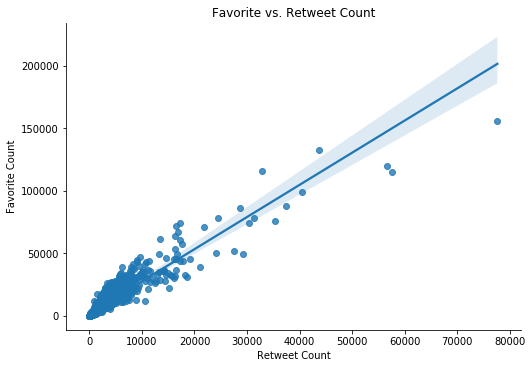

In [83]:
# Plot scatterplot of retweet vs favorite count
sns.lmplot(x="retweet_count",y="favorite_count",height = 5, aspect= 1.5, data=df_clean) 
plt.title('Favorite vs. Retweet Count')
plt.xlabel('Retweet Count')
plt.ylabel('Favorite Count');

Favorite and retweet counts are highly positively correlated. The majority of the data falls below 50000 favorites and 10000 retweets.

In [84]:
# Calculate the value counts of each dog stage
df_clean.stage.value_counts()

pupper            203
doggo              62
puppo              22
doggo, pupper       9
floofer             7
doggo, puppo        1
doggo, floofer      1
Name: stage, dtype: int64

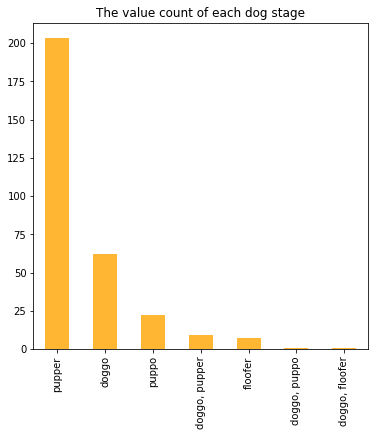

In [85]:
# Plot bar of the value counts of each dog stage
df_clean.stage.value_counts().plot(kind='bar', alpha= 0.8, figsize=(6,6), color='orange')
plt.title('The value count of each dog stage');

The most common stage of dog is pupper, the second is doggo.

In [86]:
# Calculate the sum of favorite count for each dog stage
df_clean.groupby('stage')['favorite_count'].sum()

stage
doggo             1167688
doggo, floofer      15804
doggo, pupper      112533
doggo, puppo        44338
floofer             84166
pupper            1350267
puppo              459721
Name: favorite_count, dtype: int32

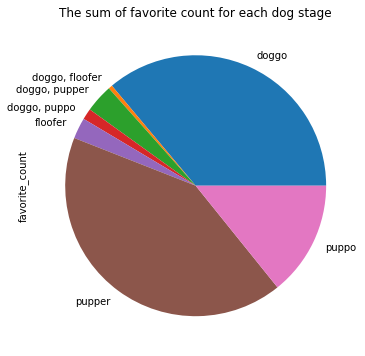

In [87]:
# Plot pie of the sum of favorite count for each dog stage
df_clean.groupby('stage')['favorite_count'].sum().plot(kind='pie', figsize=(6,6))
plt.title('The sum of favorite count for each dog stage');

The sum of favorite count of pupper stage is largest. The smallest is the sum of favorite count of doggo, floofer stage.

In [88]:
# Calculate the sum of retweet count for each dog stage
df_clean.groupby('stage')['retweet_count'].sum()

stage
doggo             404237
doggo, floofer      3052
doggo, pupper      33649
doggo, puppo       17318
floofer            30415
pupper            423759
puppo             127878
Name: retweet_count, dtype: int32

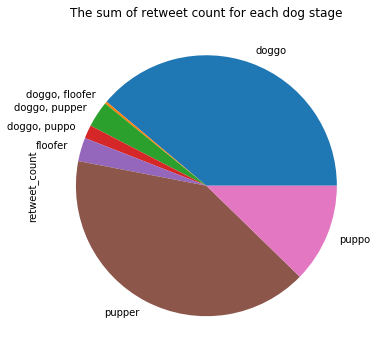

In [89]:
# Plot pie of the sum of retweet count for each dog stage
df_clean.groupby('stage')['retweet_count'].sum().plot(kind='pie', figsize=(6,6))
plt.title('The sum of retweet count for each dog stage');

The sum of retweet count for pupper stage is largest and the sum of retweet count for doggo, floofer stage is smallest.